## 1. Setup and Imports

In [23]:
# Data handling
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# PyTorch for Neural Network
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# Check PyTorch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✅ All libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✅ All libraries imported successfully!
PyTorch version: 2.9.1
Device: cpu
Pandas version: 2.3.3
NumPy version: 2.3.5


## 2. Load Merged Solar Power Data

In [24]:
# Load the merged datasets
data_dir = Path('../datasets/solar/processed')

plant1 = pd.read_csv(data_dir / 'plant1_merged.csv', parse_dates=['DATE_TIME'])
plant2 = pd.read_csv(data_dir / 'plant2_merged.csv', parse_dates=['DATE_TIME'])

print("Plant 1 Data:")
print(f"  Shape: {plant1.shape}")
print(f"  Columns: {list(plant1.columns)}")
print(f"\nPlant 2 Data:")
print(f"  Shape: {plant2.shape}")
print(f"  Columns: {list(plant2.columns)}")

# Display first few rows
print("\n" + "="*80)
print("PLANT 1 - First 5 Rows:")
print("="*80)
display(plant1.head())

print("\n" + "="*80)
print("Data Statistics:")
print("="*80)
display(plant1.describe())

Plant 1 Data:
  Shape: (3157, 8)
  Columns: ['DATE_TIME', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

Plant 2 Data:
  Shape: (3259, 8)
  Columns: ['DATE_TIME', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']

PLANT 1 - First 5 Rows:


,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,0.0,0.0,0.0,143581676.0,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,0.0,0.0,0.0,143581676.0,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,0.0,0.0,0.0,143581676.0,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,0.0,0.0,0.0,143581676.0,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,0.0,0.0,0.0,150761642.0,24.621525,22.165423,0.0



Data Statistics:


,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
count,3157,3157.000000,3157.000000,3157.000000,3.157000e+03,3157.000000,3157.000000,3157.000000
mean,2020-06-01 06:41:41.298701568,68560.019625,6704.830534,71798.457968,1.520288e+08,25.560257,31.175453,0.230103
min,2020-05-15 00:00:00,0.000000,0.000000,0.000000,2.654004e+07,20.398505,18.140415,0.000000
25%,2020-05-23 23:15:00,0.000000,0.000000,90.732143,1.521018e+08,22.739895,21.130249,0.000000
50%,2020-06-01 12:30:00,8430.196429,814.880357,66068.000000,1.535336e+08,24.680324,24.801971,0.027748
75%,2020-06-09 18:00:00,140409.892856,13752.112500,129444.625000,1.549952e+08,27.941221,41.449481,0.451576
max,2020-06-17 23:45:00,298937.785710,29150.212499,193770.000000,1.561428e+08,35.252486,65.545714,1.221652
std,NaN,88055.843520,8604.217954,65979.013517,1.038196e+07,3.351059,12.272685,0.301348


## 3. Data Preprocessing and Feature Engineering

In [25]:
def preprocess_solar_data(df):
    """
    Preprocess solar power data:
    - Extract time-based features
    - Handle missing values
    - Create additional features
    """
    df = df.copy()
    
    # Extract time-based features
    df['HOUR'] = df['DATE_TIME'].dt.hour
    df['DAY'] = df['DATE_TIME'].dt.day
    df['MONTH'] = df['DATE_TIME'].dt.month
    df['DAY_OF_WEEK'] = df['DATE_TIME'].dt.dayofweek
    df['DAY_OF_YEAR'] = df['DATE_TIME'].dt.dayofyear
    
    # Cyclical encoding for hour and month
    df['HOUR_SIN'] = np.sin(2 * np.pi * df['HOUR'] / 24)
    df['HOUR_COS'] = np.cos(2 * np.pi * df['HOUR'] / 24)
    df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH'] / 12)
    df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH'] / 12)
    
    # Create interaction features
    if 'AMBIENT_TEMPERATURE' in df.columns and 'IRRADIATION' in df.columns:
        df['TEMP_IRRAD_INTERACTION'] = df['AMBIENT_TEMPERATURE'] * df['IRRADIATION']
    
    if 'MODULE_TEMPERATURE' in df.columns and 'IRRADIATION' in df.columns:
        df['MODULE_TEMP_IRRAD'] = df['MODULE_TEMPERATURE'] * df['IRRADIATION']
    
    # Is daytime flag (hour between 6 AM and 6 PM)
    df['IS_DAYTIME'] = ((df['HOUR'] >= 6) & (df['HOUR'] <= 18)).astype(int)
    
    # Handle missing values
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    
    return df

# Preprocess Plant 1
plant1_processed = preprocess_solar_data(plant1)

print("✅ Data preprocessing completed!")
print(f"\nPlant 1 - New shape: {plant1_processed.shape}")
print(f"\nNew features added: {[col for col in plant1_processed.columns if col not in plant1.columns]}")

✅ Data preprocessing completed!

Plant 1 - New shape: (3157, 20)

New features added: ['HOUR', 'DAY', 'MONTH', 'DAY_OF_WEEK', 'DAY_OF_YEAR', 'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS', 'TEMP_IRRAD_INTERACTION', 'MODULE_TEMP_IRRAD', 'IS_DAYTIME']


## 4. Prepare Training, Validation, and Testing Data

**Split Strategy:** 70% train, 15% validation, 15% test (time-ordered, no shuffle)
**Note:** We use AC_POWER as target (actual grid output) instead of DC_POWER.

In [26]:
def prepare_ml_data(df, target_col='AC_POWER'):
    """
    Prepare data for machine learning models
    Target: AC_POWER (actual power output to grid)
    """
    # Select features
    exclude_cols = ['DATE_TIME', 'SOURCE_KEY', 'PLANT_ID', target_col]
    if 'DC_POWER' in df.columns and target_col != 'DC_POWER':
        exclude_cols.append('DC_POWER')  # Exclude DC if predicting AC
    
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    X = df[feature_cols].copy()
    y = df[target_col].copy()
    
    # Handle any remaining NaN values
    X = X.fillna(X.median())
    y = y.fillna(y.median())
    
    # Split data: 70% train, 15% validation, 15% test (time-ordered)
    # First split: 70% train, 30% temp
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, random_state=42, shuffle=False
    )
    
    # Second split: 50% of temp = 15% val, 15% test
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False
    )
    
    # Scale features (fit on train only)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to DataFrame for easier handling
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_cols, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler, feature_cols

# Prepare data for Plant 1
X_train, X_val, X_test, y_train, y_val, y_test, scaler, features = prepare_ml_data(plant1_processed)

print("="*80)
print("DATA PREPARATION COMPLETE")
print("="*80)
print(f"\nTraining set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Testing set: {X_test.shape}")
print(f"Number of features: {len(features)}")
print(f"\nFeatures used:\n{features}")
print(f"\nTarget variable: AC_POWER (actual power to grid)")
print(f"  Training range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"  Validation range: [{y_val.min():.2f}, {y_val.max():.2f}]")
print(f"  Testing range: [{y_test.min():.2f}, {y_test.max():.2f}]")

DATA PREPARATION COMPLETE

Training set: (2209, 17)
Validation set: (474, 17)
Testing set: (474, 17)
Number of features: 17

Features used:
['DAILY_YIELD', 'TOTAL_YIELD', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION', 'HOUR', 'DAY', 'MONTH', 'DAY_OF_WEEK', 'DAY_OF_YEAR', 'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS', 'TEMP_IRRAD_INTERACTION', 'MODULE_TEMP_IRRAD', 'IS_DAYTIME']

Target variable: AC_POWER (actual power to grid)
  Training range: [0.00, 29150.21]
  Validation range: [0.00, 28424.75]
  Testing range: [0.00, 29048.96]


## 5. Model 1: Linear Regression

**Theory:** Finds the best-fitting straight line through the data

**Equation:** $\hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_2 + ... + \beta_nx_n$

**Method:** Ordinary Least Squares (OLS) - minimizes sum of squared residuals

In [27]:
print("Training Linear Regression Model...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)
y_test_pred_lr = lr_model.predict(X_test)

# Evaluate
lr_train_mse = mean_squared_error(y_train, y_train_pred_lr)
lr_val_mse = mean_squared_error(y_val, y_val_pred_lr)
lr_test_mse = mean_squared_error(y_test, y_test_pred_lr)
lr_train_rmse = np.sqrt(lr_train_mse)
lr_val_rmse = np.sqrt(lr_val_mse)
lr_test_rmse = np.sqrt(lr_test_mse)
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_val_mae = mean_absolute_error(y_val, y_val_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_val_r2 = r2_score(y_val, y_val_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

print("\n" + "="*70)
print("LINEAR REGRESSION RESULTS")
print("="*70)
print(f"\n📊 Training Set:")
print(f"   MSE:  {lr_train_mse:.4f}")
print(f"   RMSE: {lr_train_rmse:.4f}")
print(f"   MAE:  {lr_train_mae:.4f}")
print(f"   R²:   {lr_train_r2:.4f}")

print(f"\n📊 Validation Set:")
print(f"   MSE:  {lr_val_mse:.4f}")
print(f"   RMSE: {lr_val_rmse:.4f}")
print(f"   MAE:  {lr_val_mae:.4f}")
print(f"   R²:   {lr_val_r2:.4f}")

print(f"\n📊 Testing Set:")
print(f"   MSE:  {lr_test_mse:.4f}")
print(f"   RMSE: {lr_test_rmse:.4f}")
print(f"   MAE:  {lr_test_mae:.4f}")
print(f"   R²:   {lr_test_r2:.4f}")
print("="*70)

Training Linear Regression Model...

LINEAR REGRESSION RESULTS

📊 Training Set:
   MSE:  430315.7742
   RMSE: 655.9846
   MAE:  348.7272
   R²:   0.9944

📊 Validation Set:
   MSE:  241238.3549
   RMSE: 491.1602
   MAE:  319.7740
   R²:   0.9963

📊 Testing Set:
   MSE:  275767.4666
   RMSE: 525.1357
   MAE:  302.1175
   R²:   0.9959


## 6. Model 2: Polynomial Regression (Degree 2)

**Theory:** Extends linear regression by adding polynomial terms to capture non-linear relationships

**Equation:** $\hat{y} = \beta_0 + \beta_1x_1 + \beta_2x_1^2 + \beta_3x_2 + \beta_4x_2^2 + ...$

**Method:** Create polynomial features, then apply linear regression

In [28]:
print("Training Polynomial Regression Model (Degree 2)...")

# Create polynomial features (degree 2, interaction_only to avoid explosion)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

print(f"\n📊 Polynomial features created: {X_train_poly.shape[1]} features (from {X_train.shape[1]} original)")
print(f"   Using interaction_only=True to reduce feature explosion")

# Train polynomial regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# Predictions
y_train_pred_poly = poly_model.predict(X_train_poly)
y_val_pred_poly = poly_model.predict(X_val_poly)
y_test_pred_poly = poly_model.predict(X_test_poly)

# Evaluate
poly_train_mse = mean_squared_error(y_train, y_train_pred_poly)
poly_val_mse = mean_squared_error(y_val, y_val_pred_poly)
poly_test_mse = mean_squared_error(y_test, y_test_pred_poly)
poly_train_rmse = np.sqrt(poly_train_mse)
poly_val_rmse = np.sqrt(poly_val_mse)
poly_test_rmse = np.sqrt(poly_test_mse)
poly_train_mae = mean_absolute_error(y_train, y_train_pred_poly)
poly_val_mae = mean_absolute_error(y_val, y_val_pred_poly)
poly_test_mae = mean_absolute_error(y_test, y_test_pred_poly)
poly_train_r2 = r2_score(y_train, y_train_pred_poly)
poly_val_r2 = r2_score(y_val, y_val_pred_poly)
poly_test_r2 = r2_score(y_test, y_test_pred_poly)

print("\n" + "="*70)
print("POLYNOMIAL REGRESSION RESULTS")
print("="*70)
print(f"\n📊 Training Set:")
print(f"   MSE:  {poly_train_mse:.4f}")
print(f"   RMSE: {poly_train_rmse:.4f}")
print(f"   MAE:  {poly_train_mae:.4f}")
print(f"   R²:   {poly_train_r2:.4f}")

print(f"\n📊 Validation Set:")
print(f"   MSE:  {poly_val_mse:.4f}")
print(f"   RMSE: {poly_val_rmse:.4f}")
print(f"   MAE:  {poly_val_mae:.4f}")
print(f"   R²:   {poly_val_r2:.4f}")

print(f"\n📊 Testing Set:")
print(f"   MSE:  {poly_test_mse:.4f}")
print(f"   RMSE: {poly_test_rmse:.4f}")
print(f"   MAE:  {poly_test_mae:.4f}")
print(f"   R²:   {poly_test_r2:.4f}")
print("="*70)

Training Polynomial Regression Model (Degree 2)...

📊 Polynomial features created: 153 features (from 17 original)
   Using interaction_only=True to reduce feature explosion

POLYNOMIAL REGRESSION RESULTS

📊 Training Set:
   MSE:  316007.5948
   RMSE: 562.1455
   MAE:  271.5986
   R²:   0.9959

📊 Validation Set:
   MSE:  368058.1812
   RMSE: 606.6780
   MAE:  360.9276
   R²:   0.9944

📊 Testing Set:
   MSE:  416598.0380
   RMSE: 645.4441
   MAE:  409.6799
   R²:   0.9938


## 7. Model 3: Decision Tree Regressor

**Theory:** Learns decision rules from data features to make predictions

**Method:** Recursively splits data based on features to minimize variance

**Advantages:** Can capture non-linear relationships without feature engineering

In [29]:
print("Training Decision Tree Regressor Model...")

dt_model = DecisionTreeRegressor(
    max_depth=15,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
dt_model.fit(X_train, y_train)

# Predictions
y_train_pred_dt = dt_model.predict(X_train)
y_val_pred_dt = dt_model.predict(X_val)
y_test_pred_dt = dt_model.predict(X_test)

# Evaluate
dt_train_mse = mean_squared_error(y_train, y_train_pred_dt)
dt_val_mse = mean_squared_error(y_val, y_val_pred_dt)
dt_test_mse = mean_squared_error(y_test, y_test_pred_dt)
dt_train_rmse = np.sqrt(dt_train_mse)
dt_val_rmse = np.sqrt(dt_val_mse)
dt_test_rmse = np.sqrt(dt_test_mse)
dt_train_mae = mean_absolute_error(y_train, y_train_pred_dt)
dt_val_mae = mean_absolute_error(y_val, y_val_pred_dt)
dt_test_mae = mean_absolute_error(y_test, y_test_pred_dt)
dt_train_r2 = r2_score(y_train, y_train_pred_dt)
dt_val_r2 = r2_score(y_val, y_val_pred_dt)
dt_test_r2 = r2_score(y_test, y_test_pred_dt)

print("\n" + "="*70)
print("DECISION TREE REGRESSOR RESULTS")
print("="*70)
print(f"\n📊 Training Set:")
print(f"   MSE:  {dt_train_mse:.4f}")
print(f"   RMSE: {dt_train_rmse:.4f}")
print(f"   MAE:  {dt_train_mae:.4f}")
print(f"   R²:   {dt_train_r2:.4f}")

print(f"\n📊 Validation Set:")
print(f"   MSE:  {dt_val_mse:.4f}")
print(f"   RMSE: {dt_val_rmse:.4f}")
print(f"   MAE:  {dt_val_mae:.4f}")
print(f"   R²:   {dt_val_r2:.4f}")

print(f"\n📊 Testing Set:")
print(f"   MSE:  {dt_test_mse:.4f}")
print(f"   RMSE: {dt_test_rmse:.4f}")
print(f"   MAE:  {dt_test_mae:.4f}")
print(f"   R²:   {dt_test_r2:.4f}")
print("="*70)

Training Decision Tree Regressor Model...

DECISION TREE REGRESSOR RESULTS

📊 Training Set:
   MSE:  271312.4586
   RMSE: 520.8766
   MAE:  239.3996
   R²:   0.9965

📊 Validation Set:
   MSE:  329773.9226
   RMSE: 574.2595
   MAE:  294.3756
   R²:   0.9950

📊 Testing Set:
   MSE:  358915.6446
   RMSE: 599.0957
   MAE:  292.3090
   R²:   0.9947


## 8. Model 4: Random Forest Regressor

**Theory:** Ensemble of decision trees - combines multiple trees to improve predictions

**Method:** 
- Bootstrap aggregating (bagging) of decision trees
- Random feature selection at each split
- Final prediction = average of all tree predictions

**Advantages:** More robust and accurate than single decision tree

In [30]:
print("Training Random Forest Regressor Model...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
rf_model.fit(X_train, y_train)

# Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Evaluate
rf_train_mse = mean_squared_error(y_train, y_train_pred_rf)
rf_val_mse = mean_squared_error(y_val, y_val_pred_rf)
rf_test_mse = mean_squared_error(y_test, y_test_pred_rf)
rf_train_rmse = np.sqrt(rf_train_mse)
rf_val_rmse = np.sqrt(rf_val_mse)
rf_test_rmse = np.sqrt(rf_test_mse)
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_val_mae = mean_absolute_error(y_val, y_val_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_val_r2 = r2_score(y_val, y_val_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

print("\n" + "="*70)
print("RANDOM FOREST REGRESSOR RESULTS")
print("="*70)
print(f"\n📊 Training Set:")
print(f"   MSE:  {rf_train_mse:.4f}")
print(f"   RMSE: {rf_train_rmse:.4f}")
print(f"   MAE:  {rf_train_mae:.4f}")
print(f"   R²:   {rf_train_r2:.4f}")

print(f"\n📊 Validation Set:")
print(f"   MSE:  {rf_val_mse:.4f}")
print(f"   RMSE: {rf_val_rmse:.4f}")
print(f"   MAE:  {rf_val_mae:.4f}")
print(f"   R²:   {rf_val_r2:.4f}")

print(f"\n📊 Testing Set:")
print(f"   MSE:  {rf_test_mse:.4f}")
print(f"   RMSE: {rf_test_rmse:.4f}")
print(f"   MAE:  {rf_test_mae:.4f}")
print(f"   R²:   {rf_test_r2:.4f}")
print("="*70)

Training Random Forest Regressor Model...

RANDOM FOREST REGRESSOR RESULTS

📊 Training Set:
   MSE:  179824.1475
   RMSE: 424.0568
   MAE:  181.1499
   R²:   0.9977

📊 Validation Set:
   MSE:  348133.5992
   RMSE: 590.0285
   MAE:  297.2716
   R²:   0.9947

📊 Testing Set:
   MSE:  401175.6717
   RMSE: 633.3843
   MAE:  292.0784
   R²:   0.9941

RANDOM FOREST REGRESSOR RESULTS

📊 Training Set:
   MSE:  179824.1475
   RMSE: 424.0568
   MAE:  181.1499
   R²:   0.9977

📊 Validation Set:
   MSE:  348133.5992
   RMSE: 590.0285
   MAE:  297.2716
   R²:   0.9947

📊 Testing Set:
   MSE:  401175.6717
   RMSE: 633.3843
   MAE:  292.0784
   R²:   0.9941


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


## 9. Model 5: Neural Network (PyTorch)

**Theory:** Multi-layer perceptron with backpropagation

**Architecture:**
- Input layer: Number of features
- Hidden layer 1: 64 neurons + ReLU activation
- Hidden layer 2: 32 neurons + ReLU activation  
- Hidden layer 3: 16 neurons + ReLU activation
- Output layer: 1 neuron (regression output)

**Training:** Adam optimizer, MSE loss, backpropagation

### 9.1 Prepare Data for PyTorch

In [31]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values).to(device)
y_train_tensor = torch.FloatTensor(y_train.values).reshape(-1, 1).to(device)
X_val_tensor = torch.FloatTensor(X_val.values).to(device)
y_val_tensor = torch.FloatTensor(y_val.values).reshape(-1, 1).to(device)
X_test_tensor = torch.FloatTensor(X_test.values).to(device)
y_test_tensor = torch.FloatTensor(y_test.values).reshape(-1, 1).to(device)

# Create DataLoader for batch training
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("✅ Data converted to PyTorch tensors")
print(f"\n📦 Batch size: {batch_size}")
print(f"📦 Number of batches: {len(train_loader)}")
print(f"\n🔢 Tensor shapes:")
print(f"   X_train: {X_train_tensor.shape}")
print(f"   y_train: {y_train_tensor.shape}")
print(f"   X_val: {X_val_tensor.shape}")
print(f"   y_val: {y_val_tensor.shape}")
print(f"   X_test: {X_test_tensor.shape}")
print(f"   y_test: {y_test_tensor.shape}")

✅ Data converted to PyTorch tensors

📦 Batch size: 64
📦 Number of batches: 35

🔢 Tensor shapes:
   X_train: torch.Size([2209, 17])
   y_train: torch.Size([2209, 1])
   X_val: torch.Size([474, 17])
   y_val: torch.Size([474, 1])
   X_test: torch.Size([474, 17])
   y_test: torch.Size([474, 1])


### 9.2 Define Neural Network Architecture

In [32]:
class SolarPowerNN(nn.Module):
    def __init__(self, input_size):
        super(SolarPowerNN, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        # Forward pass with ReLU activations
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation for regression output
        return x

# Initialize model
input_size = X_train.shape[1]
nn_model = SolarPowerNN(input_size).to(device)

print("\n" + "="*70)
print("NEURAL NETWORK ARCHITECTURE")
print("="*70)
print(nn_model)
print("\n" + "="*70)

# Count parameters
total_params = sum(p.numel() for p in nn_model.parameters())
trainable_params = sum(p.numel() for p in nn_model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


NEURAL NETWORK ARCHITECTURE
SolarPowerNN(
  (fc1): Linear(in_features=17, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
)


Total parameters: 3,777
Trainable parameters: 3,777


### 9.3 Train Neural Network

In [33]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# Training parameters
num_epochs = 100
train_losses = []
val_losses = []

print("\n" + "="*70)
print("TRAINING NEURAL NETWORK")
print("="*70)
print(f"Epochs: {num_epochs}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: 0.001")
print(f"Optimizer: Adam")
print(f"Loss function: MSE")
print("\nStarting training...\n")

# Training loop
for epoch in range(num_epochs):
    nn_model.train()
    epoch_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = nn_model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation loss (using validation set, not test set)
    nn_model.eval()
    with torch.no_grad():
        val_outputs = nn_model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor).item()
        val_losses.append(val_loss)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("\n✅ Training completed!")


TRAINING NEURAL NETWORK
Epochs: 100
Batch size: 64
Learning rate: 0.001
Optimizer: Adam
Loss function: MSE

Starting training...

Epoch [10/100] - Train Loss: 10940851.6000, Val Loss: 6748614.0000
Epoch [10/100] - Train Loss: 10940851.6000, Val Loss: 6748614.0000
Epoch [20/100] - Train Loss: 6498282.0500, Val Loss: 1882447.2500
Epoch [20/100] - Train Loss: 6498282.0500, Val Loss: 1882447.2500
Epoch [30/100] - Train Loss: 6708368.1857, Val Loss: 1512506.7500
Epoch [30/100] - Train Loss: 6708368.1857, Val Loss: 1512506.7500
Epoch [40/100] - Train Loss: 6672102.4571, Val Loss: 1623876.8750
Epoch [40/100] - Train Loss: 6672102.4571, Val Loss: 1623876.8750
Epoch [50/100] - Train Loss: 7049791.4286, Val Loss: 1087837.2500
Epoch [50/100] - Train Loss: 7049791.4286, Val Loss: 1087837.2500
Epoch [60/100] - Train Loss: 6439027.1250, Val Loss: 1211950.5000
Epoch [60/100] - Train Loss: 6439027.1250, Val Loss: 1211950.5000
Epoch [70/100] - Train Loss: 6145363.1571, Val Loss: 810416.5000
Epoch [70/

### 9.4 Evaluate Neural Network

In [34]:
# Make predictions
nn_model.eval()
with torch.no_grad():
    y_train_pred_nn_tensor = nn_model(X_train_tensor)
    y_val_pred_nn_tensor = nn_model(X_val_tensor)
    y_test_pred_nn_tensor = nn_model(X_test_tensor)

# Convert to numpy
y_train_pred_nn = y_train_pred_nn_tensor.cpu().numpy().flatten()
y_val_pred_nn = y_val_pred_nn_tensor.cpu().numpy().flatten()
y_test_pred_nn = y_test_pred_nn_tensor.cpu().numpy().flatten()

# Evaluate
nn_train_mse = mean_squared_error(y_train, y_train_pred_nn)
nn_val_mse = mean_squared_error(y_val, y_val_pred_nn)
nn_test_mse = mean_squared_error(y_test, y_test_pred_nn)
nn_train_rmse = np.sqrt(nn_train_mse)
nn_val_rmse = np.sqrt(nn_val_mse)
nn_test_rmse = np.sqrt(nn_test_mse)
nn_train_mae = mean_absolute_error(y_train, y_train_pred_nn)
nn_val_mae = mean_absolute_error(y_val, y_val_pred_nn)
nn_test_mae = mean_absolute_error(y_test, y_test_pred_nn)
nn_train_r2 = r2_score(y_train, y_train_pred_nn)
nn_val_r2 = r2_score(y_val, y_val_pred_nn)
nn_test_r2 = r2_score(y_test, y_test_pred_nn)

print("\n" + "="*70)
print("NEURAL NETWORK RESULTS")
print("="*70)
print(f"\n📊 Training Set:")
print(f"   MSE:  {nn_train_mse:.4f}")
print(f"   RMSE: {nn_train_rmse:.4f}")
print(f"   MAE:  {nn_train_mae:.4f}")
print(f"   R²:   {nn_train_r2:.4f}")

print(f"\n📊 Validation Set:")
print(f"   MSE:  {nn_val_mse:.4f}")
print(f"   RMSE: {nn_val_rmse:.4f}")
print(f"   MAE:  {nn_val_mae:.4f}")
print(f"   R²:   {nn_val_r2:.4f}")

print(f"\n📊 Testing Set:")
print(f"   MSE:  {nn_test_mse:.4f}")
print(f"   RMSE: {nn_test_rmse:.4f}")
print(f"   MAE:  {nn_test_mae:.4f}")
print(f"   R²:   {nn_test_r2:.4f}")
print("="*70)


NEURAL NETWORK RESULTS

📊 Training Set:
   MSE:  1396671.1667
   RMSE: 1181.8084
   MAE:  667.3084
   R²:   0.9819

📊 Validation Set:
   MSE:  1361401.1698
   RMSE: 1166.7910
   MAE:  663.1382
   R²:   0.9794

📊 Testing Set:
   MSE:  2049118.1294
   RMSE: 1431.4741
   MAE:  815.1295
   R²:   0.9697


### 9.5 Plot Training History

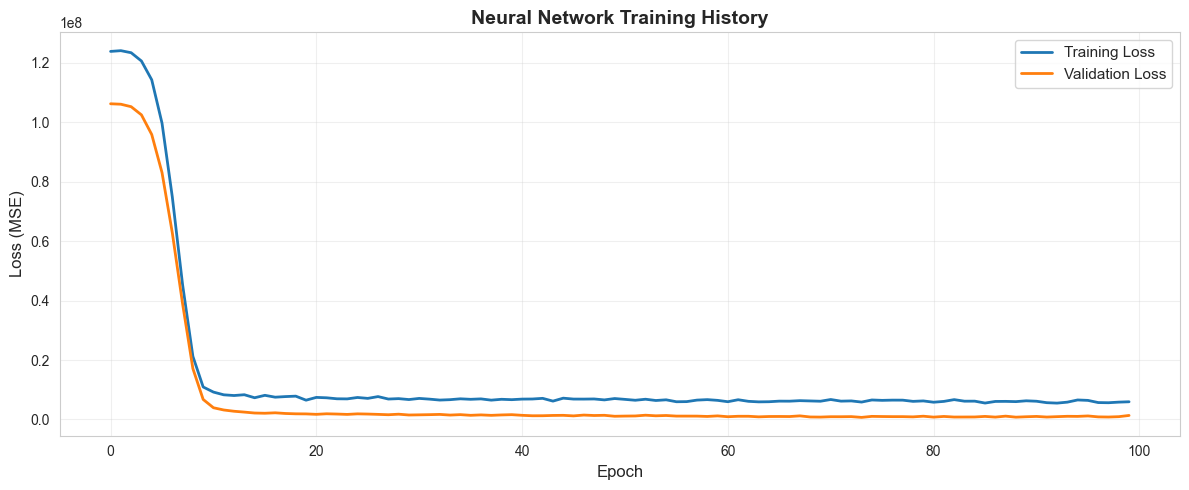


✅ Training history plot saved as 'nn_training_history.png'


In [35]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Neural Network Training History', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Training history plot saved as 'nn_training_history.png'")

## 10. Model Comparison

In [36]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Polynomial Regression', 'Decision Tree', 'Random Forest', 'Neural Network'],
    'Train_RMSE': [lr_train_rmse, poly_train_rmse, dt_train_rmse, rf_train_rmse, nn_train_rmse],
    'Val_RMSE': [lr_val_rmse, poly_val_rmse, dt_val_rmse, rf_val_rmse, nn_val_rmse],
    'Test_RMSE': [lr_test_rmse, poly_test_rmse, dt_test_rmse, rf_test_rmse, nn_test_rmse],
    'Train_MAE': [lr_train_mae, poly_train_mae, dt_train_mae, rf_train_mae, nn_train_mae],
    'Val_MAE': [lr_val_mae, poly_val_mae, dt_val_mae, rf_val_mae, nn_val_mae],
    'Test_MAE': [lr_test_mae, poly_test_mae, dt_test_mae, rf_test_mae, nn_test_mae],
    'Train_R²': [lr_train_r2, poly_train_r2, dt_train_r2, rf_train_r2, nn_train_r2],
    'Val_R²': [lr_val_r2, poly_val_r2, dt_val_r2, rf_val_r2, nn_val_r2],
    'Test_R²': [lr_test_r2, poly_test_r2, dt_test_r2, rf_test_r2, nn_test_r2]
})

# Sort by Test R² (descending)
results = results.sort_values('Test_R²', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("MODEL COMPARISON RESULTS - SOLAR POWER PREDICTION")
print("="*100)
print(results.to_string(index=False))
print("="*100)

# Find best model
best_model = results.iloc[0]['Model']
best_r2 = results.iloc[0]['Test_R²']
best_rmse = results.iloc[0]['Test_RMSE']
best_mae = results.iloc[0]['Test_MAE']

print(f"\n🏆 Best Model: {best_model}")
print(f"   Test R² Score: {best_r2:.4f}")
print(f"   Test RMSE: {best_rmse:.4f}")
print(f"   Test MAE: {best_mae:.4f}")


MODEL COMPARISON RESULTS - SOLAR POWER PREDICTION
                Model  Train_RMSE    Val_RMSE   Test_RMSE  Train_MAE    Val_MAE   Test_MAE  Train_R²   Val_R²  Test_R²
    Linear Regression  655.984584  491.160213  525.135665 348.727237 319.773993 302.117469  0.994414 0.996343 0.995922
        Decision Tree  520.876625  574.259456  599.095689 239.399562 294.375607 292.308959  0.996478 0.995001 0.994692
        Random Forest  424.056774  590.028473  633.384300 181.149865 297.271560 292.078383  0.997666 0.994723 0.994067
Polynomial Regression  562.145528  606.677988  645.444063 271.598650 360.927632 409.679911  0.995898 0.994421 0.993839
       Neural Network 1181.808431 1166.790971 1431.474111 667.308449 663.138237 815.129510  0.981869 0.979364 0.969696

🏆 Best Model: Linear Regression
   Test R² Score: 0.9959
   Test RMSE: 525.1357
   Test MAE: 302.1175


### 10.1 Visualize Model Comparison

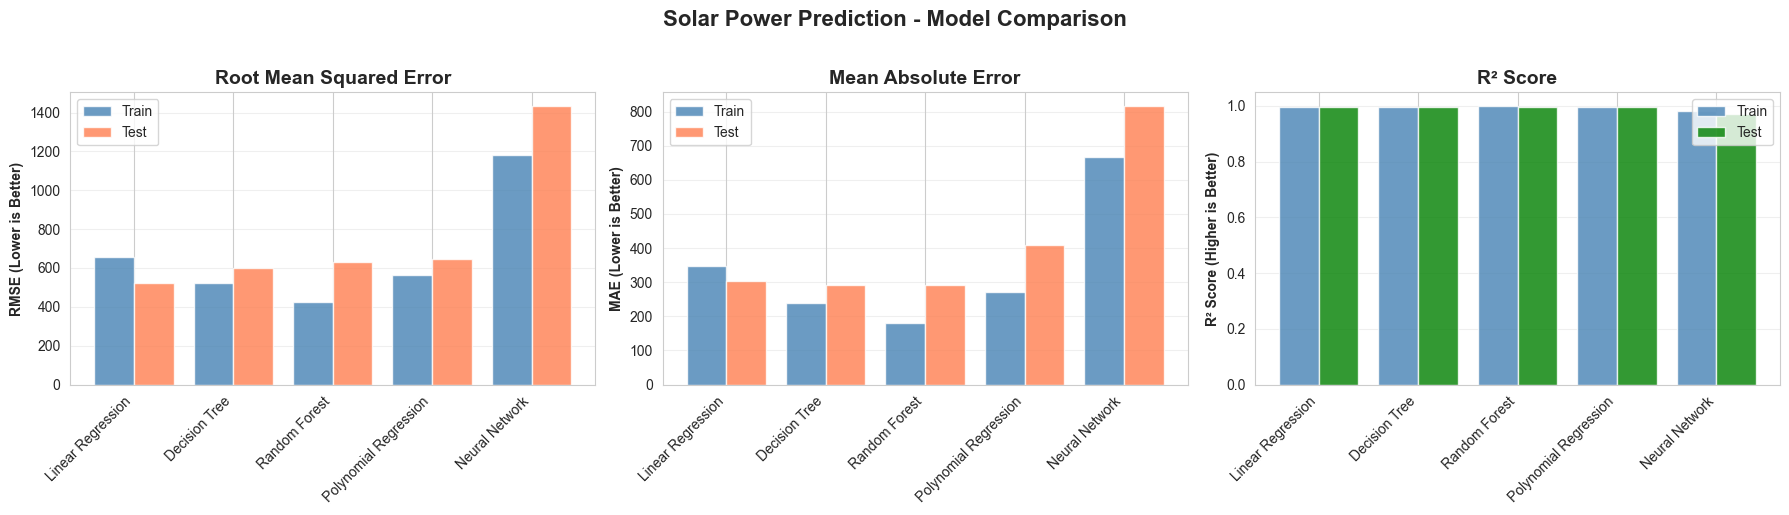


✅ Comparison plot saved as 'model_comparison.png'


In [37]:
# Create comparison plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RMSE comparison
x_pos = np.arange(len(results))
axes[0].bar(x_pos - 0.2, results['Train_RMSE'], 0.4, label='Train', color='steelblue', alpha=0.8)
axes[0].bar(x_pos + 0.2, results['Test_RMSE'], 0.4, label='Test', color='coral', alpha=0.8)
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results['Model'], rotation=45, ha='right')
axes[0].set_ylabel('RMSE (Lower is Better)', fontweight='bold')
axes[0].set_title('Root Mean Squared Error', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# MAE comparison
axes[1].bar(x_pos - 0.2, results['Train_MAE'], 0.4, label='Train', color='steelblue', alpha=0.8)
axes[1].bar(x_pos + 0.2, results['Test_MAE'], 0.4, label='Test', color='coral', alpha=0.8)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(results['Model'], rotation=45, ha='right')
axes[1].set_ylabel('MAE (Lower is Better)', fontweight='bold')
axes[1].set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# R² comparison
axes[2].bar(x_pos - 0.2, results['Train_R²'], 0.4, label='Train', color='steelblue', alpha=0.8)
axes[2].bar(x_pos + 0.2, results['Test_R²'], 0.4, label='Test', color='green', alpha=0.8)
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(results['Model'], rotation=45, ha='right')
axes[2].set_ylabel('R² Score (Higher is Better)', fontweight='bold')
axes[2].set_title('R² Score', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Solar Power Prediction - Model Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparison plot saved as 'model_comparison.png'")

## 11. Prediction Visualization

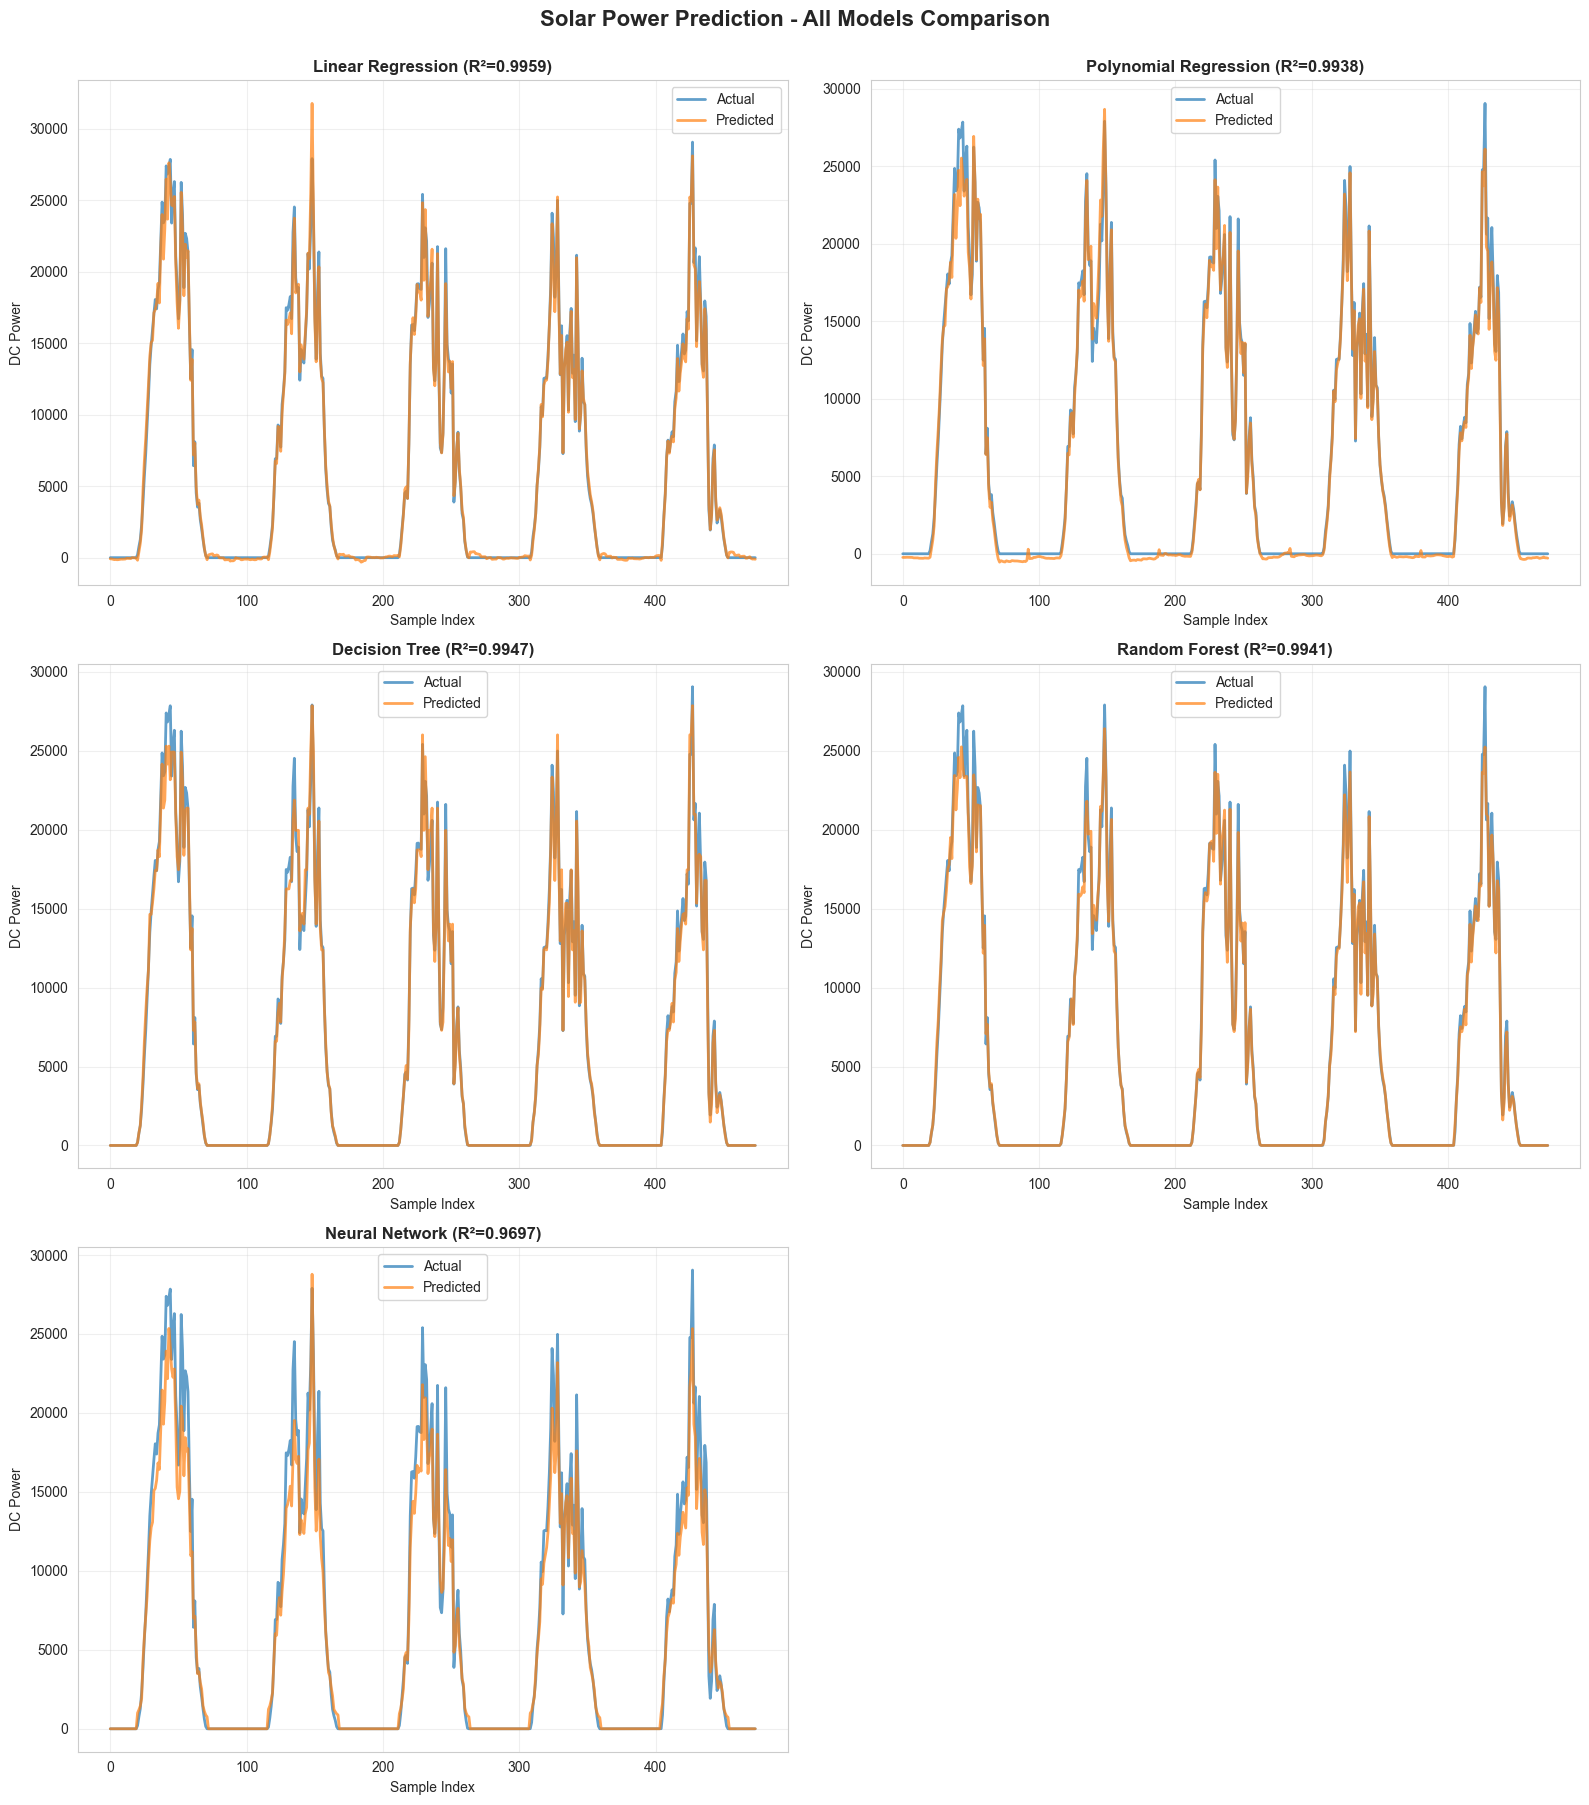


✅ Predictions plot saved as 'predictions_comparison.png'


In [38]:
# Plot predictions vs actual for all models
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

# Sample indices for visualization (first 500 test points)
sample_size = min(500, len(y_test))

models_data = [
    ('Linear Regression', y_test_pred_lr, lr_test_r2),
    ('Polynomial Regression', y_test_pred_poly, poly_test_r2),
    ('Decision Tree', y_test_pred_dt, dt_test_r2),
    ('Random Forest', y_test_pred_rf, rf_test_r2),
    ('Neural Network', y_test_pred_nn, nn_test_r2)
]

for idx, (name, pred, r2) in enumerate(models_data):
    axes[idx].plot(y_test.values[:sample_size], label='Actual', linewidth=2, alpha=0.7)
    axes[idx].plot(pred[:sample_size], label='Predicted', linewidth=2, alpha=0.7)
    axes[idx].set_title(f'{name} (R²={r2:.4f})', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Sample Index')
    axes[idx].set_ylabel('DC Power')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

# Hide last subplot
axes[5].axis('off')

plt.suptitle('Solar Power Prediction - All Models Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig('predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Predictions plot saved as 'predictions_comparison.png'")

## 12. Feature Importance (Random Forest)

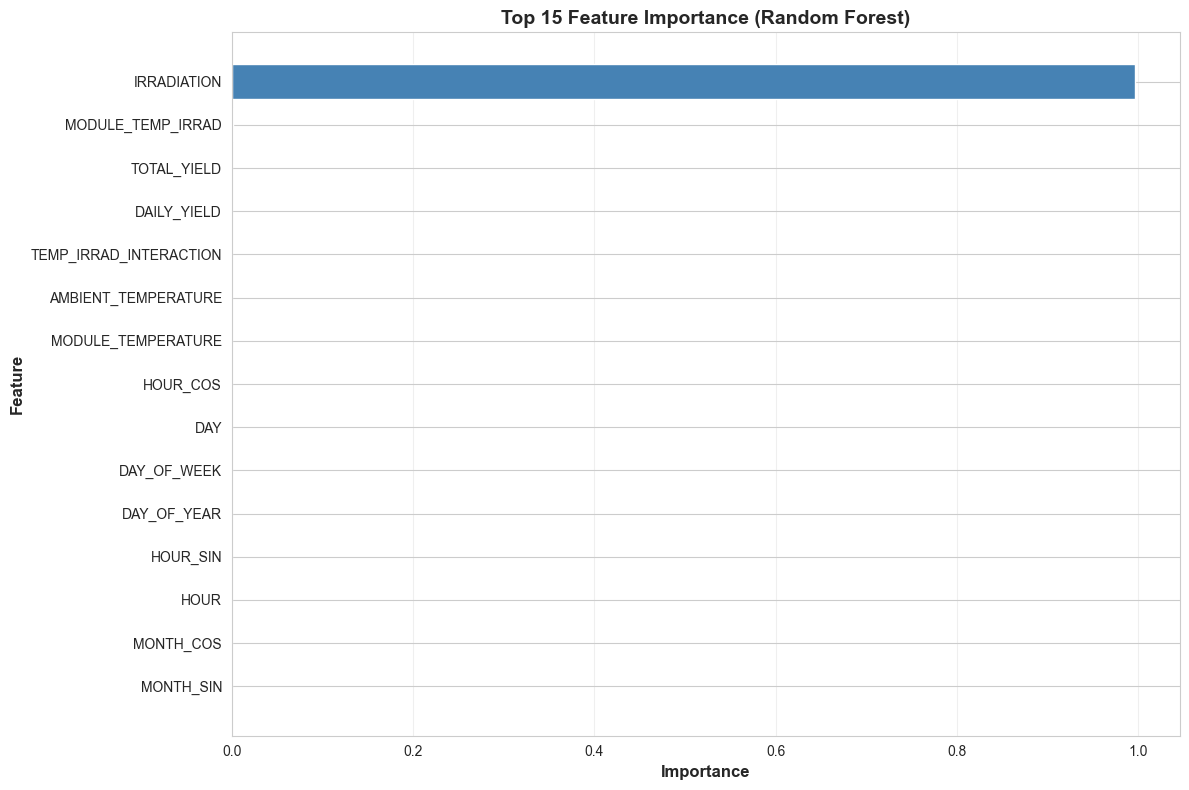


✅ Feature importance plot saved as 'feature_importance.png'

Top 10 Most Important Features:
               Feature  Importance
           IRRADIATION    0.996536
     MODULE_TEMP_IRRAD    0.001094
           TOTAL_YIELD    0.000429
           DAILY_YIELD    0.000390
TEMP_IRRAD_INTERACTION    0.000298
   AMBIENT_TEMPERATURE    0.000253
    MODULE_TEMPERATURE    0.000246
              HOUR_COS    0.000227
                   DAY    0.000173
           DAY_OF_WEEK    0.000155


In [39]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_n = min(15, len(feature_importance))
plt.barh(feature_importance['Feature'][:top_n], feature_importance['Importance'][:top_n], color='steelblue')
plt.xlabel('Importance', fontweight='bold', fontsize=12)
plt.ylabel('Feature', fontweight='bold', fontsize=12)
plt.title(f'Top {top_n} Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Feature importance plot saved as 'feature_importance.png'")
print(f"\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

## 13. Summary and Conclusions

In [40]:
print("\n" + "="*80)
print("SOLAR POWER PREDICTION - FINAL SUMMARY")
print("="*80)

print("\n📊 Models Trained:")
for idx, row in results.iterrows():
    print(f"  {idx+1}. {row['Model']}:")
    print(f"     Test R² = {row['Test_R²']:.4f}, RMSE = {row['Test_RMSE']:.4f}, MAE = {row['Test_MAE']:.4f}")

print(f"\n🏆 Best Performing Model: {best_model}")
print(f"   Test R² Score: {best_r2:.4f}")
print(f"   Test RMSE: {best_rmse:.4f}")
print(f"   Test MAE: {best_mae:.4f}")

print("\n📁 Generated Outputs:")
print("  - model_comparison.png")
print("  - predictions_comparison.png")
print("  - feature_importance.png")
print("  - nn_training_history.png")

print("\n✅ All models successfully trained and evaluated!")
print("="*80)


SOLAR POWER PREDICTION - FINAL SUMMARY

📊 Models Trained:
  1. Linear Regression:
     Test R² = 0.9959, RMSE = 525.1357, MAE = 302.1175
  2. Decision Tree:
     Test R² = 0.9947, RMSE = 599.0957, MAE = 292.3090
  3. Random Forest:
     Test R² = 0.9941, RMSE = 633.3843, MAE = 292.0784
  4. Polynomial Regression:
     Test R² = 0.9938, RMSE = 645.4441, MAE = 409.6799
  5. Neural Network:
     Test R² = 0.9697, RMSE = 1431.4741, MAE = 815.1295

🏆 Best Performing Model: Linear Regression
   Test R² Score: 0.9959
   Test RMSE: 525.1357
   Test MAE: 302.1175

📁 Generated Outputs:
  - model_comparison.png
  - predictions_comparison.png
  - feature_importance.png
  - nn_training_history.png

✅ All models successfully trained and evaluated!
